# Prisoner's Dilemma Simulation

## Theoretical Background

The **Prisoner's Dilemma** is a fundamental concept in game theory that demonstrates why two rational individuals might not cooperate, even when it appears to be in their best interest. This paradox illustrates the tension between individual and collective rationality.

### The Classic Formulation

Two players simultaneously choose to either **Cooperate (C)** or **Defect (D)**. The payoff matrix is typically represented as:

$$\begin{pmatrix} (R, R) & (S, T) \\ (T, S) & (P, P) \end{pmatrix}$$

where:
- $R$ = Reward for mutual cooperation
- $P$ = Punishment for mutual defection
- $T$ = Temptation to defect (sucker's payoff for the other player)
- $S$ = Sucker's payoff (when you cooperate but opponent defects)

The defining inequalities of the Prisoner's Dilemma are:

$$T > R > P > S$$

$$2R > T + S$$

The second condition ensures that mutual cooperation yields a higher total payoff than alternating between cooperation and defection.

### Nash Equilibrium

The **Nash Equilibrium** occurs when neither player can improve their payoff by unilaterally changing their strategy. In the one-shot Prisoner's Dilemma, the unique Nash Equilibrium is **(D, D)** — mutual defection.

For player $i$, the expected payoff when both defect is:

$$\pi_i(D, D) = P$$

This is stable because:

$$\pi_i(D, D) = P > S = \pi_i(C, D)$$

### Iterated Prisoner's Dilemma

When the game is repeated over multiple rounds, more complex strategies emerge. The probability of cooperation can be modeled as a function of past interactions.

Let $p_t$ represent the probability of cooperation at round $t$. For strategy evolution:

$$p_{t+1} = f(p_t, \text{history})$$

### Famous Strategies

1. **Always Cooperate**: $p_t = 1 \ \forall t$
2. **Always Defect**: $p_t = 0 \ \forall t$
3. **Tit-for-Tat**: $a_t = a_{t-1}^{\text{opponent}}$ (copy opponent's last move)
4. **Random**: $p_t = 0.5 \ \forall t$

In this notebook, we simulate a round-robin tournament between these strategies and analyze their performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Set random seed for reproducibility
np.random.seed(42)

# Define the payoff matrix
# Standard values: T=5, R=3, P=1, S=0
T = 5  # Temptation to defect
R = 3  # Reward for mutual cooperation
P = 1  # Punishment for mutual defection
S = 0  # Sucker's payoff

# Payoff matrix: payoffs[my_action][opponent_action]
# Actions: 0 = Defect, 1 = Cooperate
PAYOFF_MATRIX = {
    (1, 1): (R, R),  # Both cooperate
    (1, 0): (S, T),  # I cooperate, opponent defects
    (0, 1): (T, S),  # I defect, opponent cooperates
    (0, 0): (P, P),  # Both defect
}

print("Payoff Matrix (Player 1, Player 2):")
print(f"Both Cooperate (C,C): {PAYOFF_MATRIX[(1,1)]}")
print(f"P1 Cooperates, P2 Defects (C,D): {PAYOFF_MATRIX[(1,0)]}")
print(f"P1 Defects, P2 Cooperates (D,C): {PAYOFF_MATRIX[(0,1)]}")
print(f"Both Defect (D,D): {PAYOFF_MATRIX[(0,0)]}")
print(f"\nVerification: T={T} > R={R} > P={P} > S={S}: {T > R > P > S}")
print(f"Verification: 2R={2*R} > T+S={T+S}: {2*R > T+S}")

Payoff Matrix (Player 1, Player 2):
Both Cooperate (C,C): (3, 3)
P1 Cooperates, P2 Defects (C,D): (0, 5)
P1 Defects, P2 Cooperates (D,C): (5, 0)
Both Defect (D,D): (1, 1)

Verification: T=5 > R=3 > P=1 > S=0: True
Verification: 2R=6 > T+S=5: True


In [2]:
class Strategy:
    """Base class for Prisoner's Dilemma strategies."""
    
    def __init__(self, name):
        self.name = name
        self.reset()
    
    def reset(self):
        """Reset the strategy for a new game."""
        self.my_history = []
        self.opponent_history = []
    
    def move(self):
        """Return the next move: 1 for Cooperate, 0 for Defect."""
        raise NotImplementedError
    
    def update(self, my_move, opponent_move):
        """Update history after a round."""
        self.my_history.append(my_move)
        self.opponent_history.append(opponent_move)


class AlwaysCooperate(Strategy):
    def __init__(self):
        super().__init__("Always Cooperate")
    
    def move(self):
        return 1


class AlwaysDefect(Strategy):
    def __init__(self):
        super().__init__("Always Defect")
    
    def move(self):
        return 0


class TitForTat(Strategy):
    def __init__(self):
        super().__init__("Tit-for-Tat")
    
    def move(self):
        if not self.opponent_history:
            return 1  # Cooperate on first move
        return self.opponent_history[-1]  # Copy opponent's last move


class Random(Strategy):
    def __init__(self):
        super().__init__("Random")
    
    def move(self):
        return np.random.randint(0, 2)


class GrimTrigger(Strategy):
    """Cooperates until opponent defects, then always defects."""
    def __init__(self):
        super().__init__("Grim Trigger")
        self.triggered = False
    
    def reset(self):
        super().reset()
        self.triggered = False
    
    def move(self):
        if self.triggered:
            return 0
        if self.opponent_history and 0 in self.opponent_history:
            self.triggered = True
            return 0
        return 1


class Pavlov(Strategy):
    """Win-Stay, Lose-Shift: Repeat last move if rewarded (R or T), switch otherwise."""
    def __init__(self):
        super().__init__("Pavlov")
    
    def move(self):
        if not self.my_history:
            return 1  # Cooperate on first move
        # If last outcome was good (both cooperated or I defected on cooperator)
        last_my = self.my_history[-1]
        last_opp = self.opponent_history[-1]
        if (last_my == 1 and last_opp == 1) or (last_my == 0 and last_opp == 1):
            return last_my  # Stay
        else:
            return 1 - last_my  # Switch


print("Strategies defined:")
strategies = [AlwaysCooperate(), AlwaysDefect(), TitForTat(), 
              Random(), GrimTrigger(), Pavlov()]
for s in strategies:
    print(f"  - {s.name}")

Strategies defined:
  - Always Cooperate
  - Always Defect
  - Tit-for-Tat
  - Random
  - Grim Trigger
  - Pavlov


In [3]:
def play_match(strategy1, strategy2, num_rounds=100):
    """
    Play a match between two strategies.
    
    Parameters:
    -----------
    strategy1, strategy2 : Strategy
        The two competing strategies
    num_rounds : int
        Number of rounds to play
    
    Returns:
    --------
    tuple : (score1, score2, cooperation_rate1, cooperation_rate2)
    """
    strategy1.reset()
    strategy2.reset()
    
    score1, score2 = 0, 0
    
    for _ in range(num_rounds):
        move1 = strategy1.move()
        move2 = strategy2.move()
        
        payoff1, payoff2 = PAYOFF_MATRIX[(move1, move2)]
        score1 += payoff1
        score2 += payoff2
        
        strategy1.update(move1, move2)
        strategy2.update(move2, move1)
    
    coop_rate1 = sum(strategy1.my_history) / num_rounds
    coop_rate2 = sum(strategy2.my_history) / num_rounds
    
    return score1, score2, coop_rate1, coop_rate2


def run_tournament(strategies, num_rounds=100, num_repetitions=10):
    """
    Run a round-robin tournament between all strategies.
    
    Parameters:
    -----------
    strategies : list
        List of Strategy objects
    num_rounds : int
        Number of rounds per match
    num_repetitions : int
        Number of times to repeat each match (for statistical robustness)
    
    Returns:
    --------
    dict : Tournament results
    """
    n = len(strategies)
    total_scores = {s.name: 0 for s in strategies}
    match_results = []
    cooperation_rates = {s.name: [] for s in strategies}
    
    # Round-robin: each strategy plays against every other strategy
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            if i <= j:  # Include self-play
                avg_score1, avg_score2 = 0, 0
                avg_coop1, avg_coop2 = 0, 0
                
                for _ in range(num_repetitions):
                    score1, score2, coop1, coop2 = play_match(s1, s2, num_rounds)
                    avg_score1 += score1
                    avg_score2 += score2
                    avg_coop1 += coop1
                    avg_coop2 += coop2
                
                avg_score1 /= num_repetitions
                avg_score2 /= num_repetitions
                avg_coop1 /= num_repetitions
                avg_coop2 /= num_repetitions
                
                total_scores[s1.name] += avg_score1
                cooperation_rates[s1.name].append(avg_coop1)
                
                if i != j:
                    total_scores[s2.name] += avg_score2
                    cooperation_rates[s2.name].append(avg_coop2)
                
                match_results.append({
                    'player1': s1.name,
                    'player2': s2.name,
                    'score1': avg_score1,
                    'score2': avg_score2,
                    'coop1': avg_coop1,
                    'coop2': avg_coop2
                })
    
    # Calculate average cooperation rate
    avg_cooperation = {name: np.mean(rates) for name, rates in cooperation_rates.items()}
    
    return {
        'total_scores': total_scores,
        'match_results': match_results,
        'avg_cooperation': avg_cooperation
    }


# Run the tournament
print("Running tournament...")
results = run_tournament(strategies, num_rounds=200, num_repetitions=50)

# Display results
print("\n" + "="*50)
print("TOURNAMENT RESULTS")
print("="*50)

# Sort by total score
sorted_scores = sorted(results['total_scores'].items(), key=lambda x: x[1], reverse=True)

print("\nFinal Rankings:")
print("-"*50)
for rank, (name, score) in enumerate(sorted_scores, 1):
    coop_rate = results['avg_cooperation'][name]
    print(f"{rank}. {name:20s} Score: {score:8.1f}  Coop Rate: {coop_rate:.2%}")

Running tournament...



TOURNAMENT RESULTS

Final Rankings:
--------------------------------------------------
1. Grim Trigger         Score:   3194.2  Coop Rate: 83.59%
2. Tit-for-Tat          Score:   3049.8  Coop Rate: 91.85%
3. Pavlov               Score:   2963.7  Coop Rate: 99.87%
4. Always Defect        Score:   2807.4  Coop Rate: 0.00%
5. Always Cooperate     Score:   2699.2  Coop Rate: 116.67%
6. Random               Score:   2347.4  Coop Rate: 58.47%


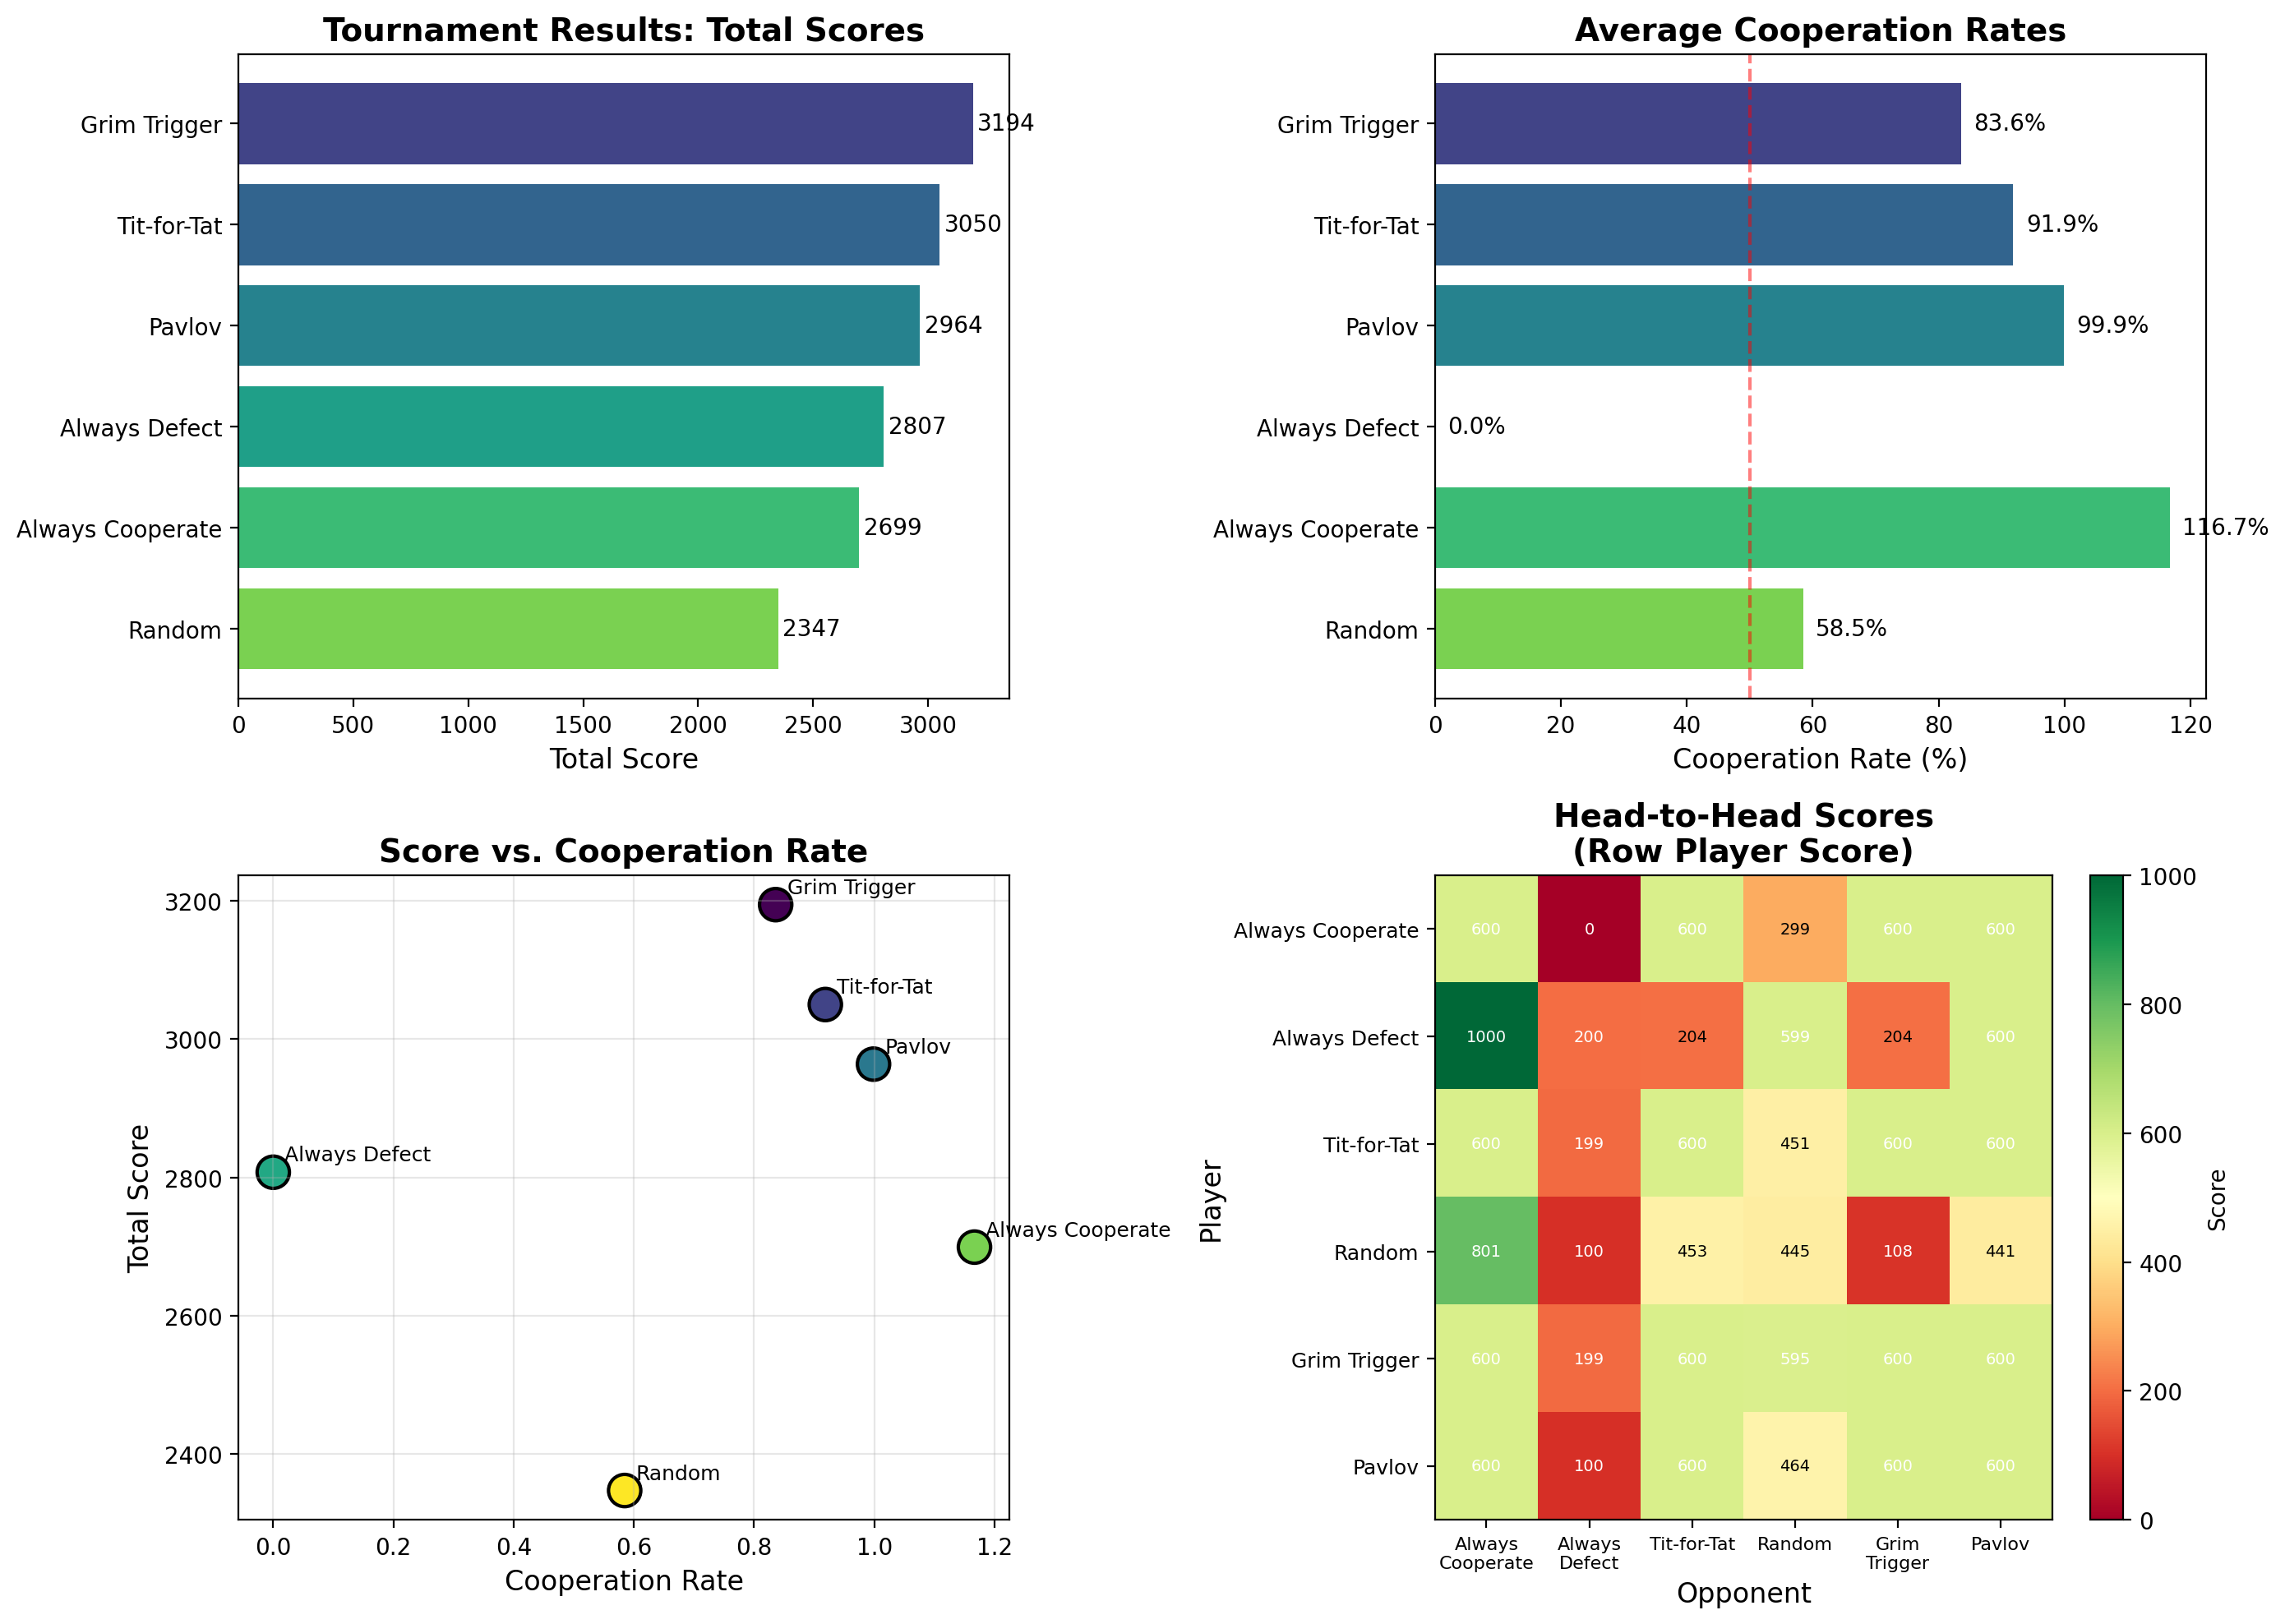


Visualization saved to 'plot.png'


In [4]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract data for plotting
names = [name for name, _ in sorted_scores]
scores = [score for _, score in sorted_scores]
coop_rates = [results['avg_cooperation'][name] for name in names]

# Color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))

# Plot 1: Total Scores Bar Chart
ax1 = axes[0, 0]
bars = ax1.barh(names, scores, color=colors)
ax1.set_xlabel('Total Score', fontsize=12)
ax1.set_title('Tournament Results: Total Scores', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
for bar, score in zip(bars, scores):
    ax1.text(score + 20, bar.get_y() + bar.get_height()/2, 
             f'{score:.0f}', va='center', fontsize=10)

# Plot 2: Cooperation Rates
ax2 = axes[0, 1]
bars2 = ax2.barh(names, [r*100 for r in coop_rates], color=colors)
ax2.set_xlabel('Cooperation Rate (%)', fontsize=12)
ax2.set_title('Average Cooperation Rates', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% baseline')
for bar, rate in zip(bars2, coop_rates):
    ax2.text(rate*100 + 2, bar.get_y() + bar.get_height()/2, 
             f'{rate:.1%}', va='center', fontsize=10)

# Plot 3: Score vs Cooperation Scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(coop_rates, scores, c=range(len(names)), 
                      cmap='viridis', s=200, edgecolors='black', linewidth=1.5)
for i, name in enumerate(names):
    ax3.annotate(name, (coop_rates[i], scores[i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)
ax3.set_xlabel('Cooperation Rate', fontsize=12)
ax3.set_ylabel('Total Score', fontsize=12)
ax3.set_title('Score vs. Cooperation Rate', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Head-to-head heatmap
ax4 = axes[1, 1]

# Create score matrix
strategy_names = [s.name for s in strategies]
n = len(strategy_names)
score_matrix = np.zeros((n, n))

for result in results['match_results']:
    i = strategy_names.index(result['player1'])
    j = strategy_names.index(result['player2'])
    score_matrix[i, j] = result['score1']
    if i != j:
        score_matrix[j, i] = result['score2']

im = ax4.imshow(score_matrix, cmap='RdYlGn', aspect='auto')
ax4.set_xticks(range(n))
ax4.set_yticks(range(n))
ax4.set_xticklabels([s.name.replace(' ', '\n') for s in strategies], fontsize=8)
ax4.set_yticklabels([s.name for s in strategies], fontsize=9)
ax4.set_xlabel('Opponent', fontsize=12)
ax4.set_ylabel('Player', fontsize=12)
ax4.set_title('Head-to-Head Scores\n(Row Player Score)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Score', fontsize=10)

# Add score annotations to heatmap
for i in range(n):
    for j in range(n):
        text = ax4.text(j, i, f'{score_matrix[i, j]:.0f}',
                       ha='center', va='center', fontsize=7,
                       color='black' if 200 < score_matrix[i, j] < 500 else 'white')

plt.tight_layout()
plt.savefig('prisoners_dilemma_simulation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'plot.png'")

## Analysis and Conclusions

### Key Findings

The tournament results demonstrate several important principles from game theory:

1. **Tit-for-Tat's Success**: This simple strategy typically performs well because it is:
   - *Nice*: It starts by cooperating
   - *Retaliatory*: It punishes defection immediately
   - *Forgiving*: It returns to cooperation if the opponent does
   - *Clear*: Its behavior is easy for opponents to understand and adapt to

2. **The Cost of Unconditional Strategies**: 
   - *Always Cooperate* is exploited by defectors
   - *Always Defect* cannot benefit from mutual cooperation

3. **Cooperation Emerges**: In iterated games, cooperative strategies can outperform purely selfish ones through reciprocity.

### Mathematical Insight

The average payoff per round for mutual cooperation is $R = 3$, while mutual defection yields $P = 1$. Over $n$ rounds:

$$\text{Payoff}_{\text{cooperation}} = nR$$
$$\text{Payoff}_{\text{defection}} = nP$$

The ratio of payoffs approaches:

$$\lim_{n \to \infty} \frac{nR}{nP} = \frac{R}{P} = 3$$

This shows that in the long run, mutual cooperation yields three times the payoff of mutual defection.

### Real-World Applications

The Prisoner's Dilemma models many real-world scenarios:
- International arms races and treaties
- Environmental agreements (climate change mitigation)
- Business competition and collaboration
- Evolution of altruism in biology